In [1]:
# country_aliases.py
"""
A mapping from country names in the JHU/CSSE dataset to those used by the
Wikipedia page for country populations.
"""

country_aliases = {
    'Cabo Verde': 'Cape Verde',
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'DR Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'Czechia': 'Czech Republic',
    'Holy See': 'Vatican City',
    'Korea, South': 'South Korea',
    'Taiwan*': 'Taiwan',
    'US': 'United States',
    'Timor-Leste': 'East Timor',
    'West Bank and Gaza': 'Palestine',
}

In [84]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# If you have saved a local copy of the CSV file as LOCAL_CSV_FILE,
# set READ_FROM_URL to True
READ_FROM_URL = True

# Start the plot on the day when the number of confirmed cases reaches MIN_CASES
MIN_CASES = 100

# Plot for MAX_DAYS days after the day on which each country reaches MIN_CASES.
MAX_DAYS = 40

#PLOT_TYPE = 'deaths'
PLOT_TYPE = 'confirmed cases'

# These are the GitHub URLs for the Johns Hopkins data in CSV format.
if PLOT_TYPE == 'confirmed cases':
    data_loc = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
                'master/csse_covid_19_data/csse_covid_19_time_series/'
                'time_series_covid19_confirmed_global.csv')
    LOCAL_CSV_FILE = 'covid-19-cases.csv'
elif PLOT_TYPE == 'deaths':
    data_loc = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
                'master/csse_covid_19_data/csse_covid_19_time_series/'
                'time_series_covid19_deaths_global.csv')
    LOCAL_CSV_FILE = 'covid-19-deaths.csv'

# Read in the data to a pandas DataFrame.
if not READ_FROM_URL:
    data_loc = LOCAL_CSV_FILE

In [4]:
df1 = pd.read_csv("covid-19-cases.csv")
df1.rename(columns={'Country/Region': 'Country'}, inplace=True)

# Read in the populations file as a Series (squeeze=True) indexed by country.
populations = pd.read_csv('country_population.csv', index_col='Country',
                          squeeze=True)

In [5]:
print(df1)

     Unnamed: 0                    Province/State                 Country  \
0             0                               NaN             Afghanistan   
1             1                               NaN                 Albania   
2             2                               NaN                 Algeria   
3             3                               NaN                 Andorra   
4             4                               NaN                  Angola   
5             5                               NaN     Antigua and Barbuda   
6             6                               NaN               Argentina   
7             7                               NaN                 Armenia   
8             8      Australian Capital Territory               Australia   
9             9                   New South Wales               Australia   
10           10                Northern Territory               Australia   
11           11                        Queensland               Australia   

In [6]:
# Group by country and sum over the different states/regions of each country.
grouped = df1.groupby('Country')
df2 = grouped.sum()
df2.rename(index=country_aliases, inplace=True)

In [7]:
print(df2)

                        Unnamed: 0         Lat         Long  1/22/20  1/23/20  \
Country                                                                         
Afghanistan                      0   33.000000    65.000000        0        0   
Albania                          1   41.153300    20.168300        0        0   
Algeria                          2   28.033900     1.659600        0        0   
Andorra                          3   42.506300     1.521800        0        0   
Angola                           4  -11.202700    17.873900        0        0   
Antigua and Barbuda              5   17.060800   -61.796400        0        0   
Argentina                        6  -38.416100   -63.616700        0        0   
Armenia                          7   40.069100    45.038200        0        0   
Australia                       92 -255.969500  1129.862300        0        0   
Austria                         16   47.516200    14.550100        0        0   
Azerbaijan                  

In [8]:
def make_bar_plot(country = "Bangladesh"):
    # Extract the Series corresponding to the case numbers for country.
    c_df = df2.loc[country, df2.columns[3:]].astype(int)
    # Convert index to a proper datetime object
    c_df.index = pd.to_datetime(c_df.index)
    c_df = c_df[c_df >= MIN_CASES]

    n = len(c_df)
    if n == 0:
        print('Too few data to plot: minimum number of {}s is {}'
                .format(PLOT_TYPE, MIN_CASES))
        sys.exit(1)

    fig = plt.Figure()
    fig = plt.Figure()

    # Arrange the subplots on a grid: the top plot (case number change) is
    # one quarter the height of the bar chart (total confirmed case numbers).
    ax2 = plt.subplot2grid((4,1), (0,0))
    ax1 = plt.subplot2grid((4,1), (1,0), rowspan=3)
    ax1.bar(range(n), c_df.values)
    # Force the x-axis to be in integers (whole number of days) in case
    # Matplotlib chooses some non-integral number of days to label).
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    c_df_change = c_df.diff()
    ax2.bar(range(n), c_df_change.values)
    ax2.set_xticks([])

    ax1.set_xlabel('Days since {} {}'.format(MIN_CASES, PLOT_TYPE))
    ax1.set_ylabel(f'Number of {PLOT_TYPE}, $N$')
    ax2.set_ylabel('$\Delta N$')

    # Add a title reporting the latest number of cases available.
    title = '{}\n{} {} on {}'.format(country, c_df[-1], PLOT_TYPE,
                c_df.index[-1].strftime('%d %B %Y'))
    plt.suptitle(title)

In [9]:
def make_comparison_plot(countries, normalize=False):
    # Extract the Series corresponding to the case numbers for countries.
    c_df = df2.loc[countries, df2.columns[3:]].astype(int)

    # Discard any columns with fewer than MIN_CASES.
    c_df = c_df[c_df >= MIN_CASES]

    if normalize:
        # Calculate confirmed case numbers per 1,000,000 population.
        c_df  = c_df.div(populations.loc[countries], axis='index') * 1000000

    # Rearrange DataFrame to give countries in columns and number of days since
    # MIN_CASES in rows.
    c_df = c_df.T.apply(lambda e: pd.Series(e.dropna().values))

    # Truncate the DataFrame after the maximum number of days to be considered.
    c_df = c_df.truncate(after=MAX_DAYS-1)

    # Plot the data.
    fig = plt.figure()
    ax = fig.add_subplot()
    for country, ser in c_df.iteritems():
        ax.plot(range(len(ser)), np.log10(ser.values), label=country)

    if not normalize:
        # Set the tick marks and labels for the absolute data.
        ymin = int(np.log10(MIN_CASES))
        ymax = int(np.log10(np.nanmax(c_df))) + 1
        yticks = np.linspace(ymin, ymax, ymax-ymin+1, dtype=int)
        yticklabels = [str(10**y) for y in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(ymin, ymax)
        ax.set_ylabel(f'Number of {PLOT_TYPE}')
    else:
        # Set the tick marks and labels for the per 1,000,000 population data.
        ax.set_ylim(np.log10(np.nanmin(c_df)), np.log10(np.nanmax(c_df)))
        ax.set_ylabel(f'Number of {PLOT_TYPE} per 1,000,000 population')

    # Label the x-axis
    ax.set_xlim(0, MAX_DAYS)
    ax.set_xlabel(f'Number of days since first {MIN_CASES} {PLOT_TYPE}')
    ax.set_xlabel(f'Number of days since first {MIN_CASES} {PLOT_TYPE}')


    def plot_threshold_lines(doubling_lifetime):
        """Add a line for the growth in numbers at a given doubling lifetime."""

        # Find the limits of the line for the current plot region.
        x = np.array([0, MAX_DAYS])
        y = np.log10(MIN_CASES) + x/doubling_lifetime * np.log10(2)
        ymin, ymax = ax.get_ylim()
        if y[1] > ymax:
            y[1] = ymax
            x[1] = doubling_lifetime/np.log10(2) * (y[1] - np.log10(MIN_CASES))
        ax.plot(x, y, ls='--', color='#aaaaaa')

        # The reason this matters is that we want to label the line at its
        # centre, rotated appropriately.
        s = f'Doubling every {doubling_lifetime} days'
        p1 = ax.transData.transform_point((x[0], y[0]))
        p2 = ax.transData.transform_point((x[1], y[1]))
        xylabel = ((x[0]+x[1])/2, (y[0]+y[1])/2)

        dy = (p2[1] - p1[1])
        dx = (p2[0] - p1[0])
        angle = np.degrees(np.arctan2(dy, dx))
        ax.annotate(s, xy=xylabel, ha='center', va='center', rotation=angle)

    if not normalize:
        # If we're plotting absolute numbers, indicate the doubling time.
        plot_threshold_lines(2)
        plot_threshold_lines(3)
        plot_threshold_lines(5)

    ax.legend()

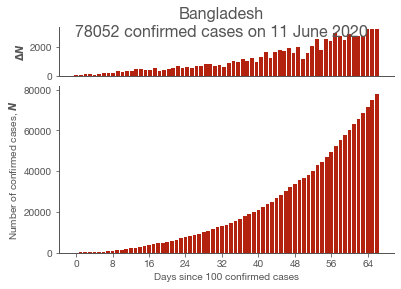

In [10]:
make_bar_plot('Bangladesh')
plt.show()


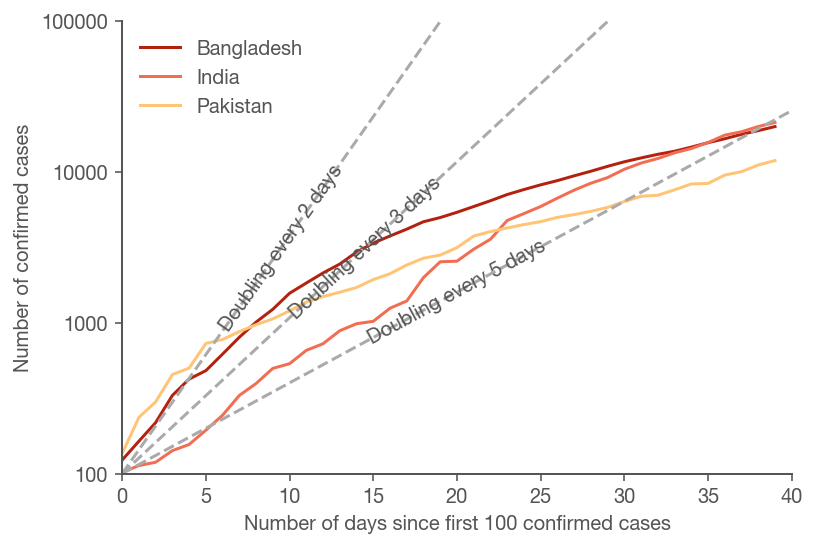

In [85]:
countries = ["Bangladesh", "India", "Pakistan"]
#countries = ['Italy', 'Spain', 'United Kingdom', 'United States',
#             'Japan', 'France', 'South Korea', 'China', 'Austria', 'Iran']
make_comparison_plot(countries, normalize=False)
plt.show()

In [91]:
# from Worldometer, arcived at
# http://web.archive.org/web/20200422135436/https://www.worldometers.info/coronavirus/
country = "Bangladesh"
bd_cases_per_date = df2.loc[country, df2.columns[3:]].astype(int)
date = bd_cases_per_date.index.get_values()
cases = bd_cases_per_date.get_values()
#print(date, cases)

allcases = [[date[i], cases[i], 0, 0] for i in range(70, len(date))]

In [98]:
print(allcases[0])
print(date[69], cases[69])
allcases[0][2] = 54/51-1
allcases[0][3] = 0.7/allcases[0][2]
print(allcases[0])
print(allcases[1])
print(allcases[2])


['4/1/20', 54, 0.05882352941176472, 11.899999999999997]
3/31/20 51
['4/1/20', 54, 0.05882352941176472, 11.899999999999997]
['4/2/20', 56, 0.03703703703703698, 18.900000000000027]
['4/3/20', 61, 0.08928571428571419, 7.840000000000008]


In [94]:
for i in range(len(allcases)):
    if allcases[i][2] == 0.0:
        allcases[i][2] = allcases[i][1]/allcases[i-1][1]-1
    if allcases[i][3] == 0.0:
        allcases[i][3] = 0.7/allcases[i][2]
        # uncomment to check output

#print(allcases)
#print((allcases[1][2]))

In [95]:
doublingtimes = [row[3] for row in allcases]
dates = [row[0] for row in allcases];

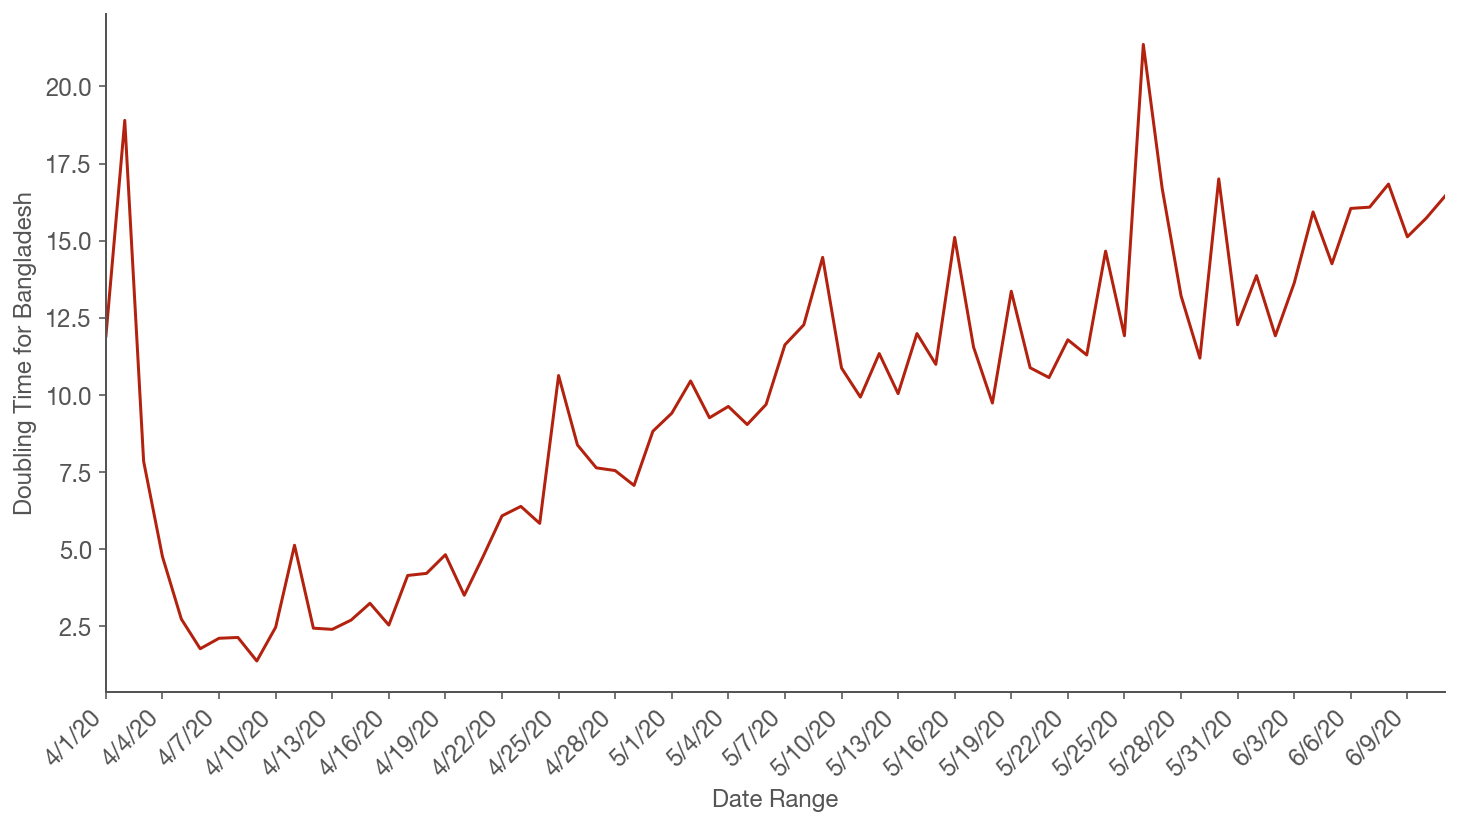

In [97]:
plt.figure(figsize=(12, 6))
plt.autoscale(enable=True, axis='x', tight=True)
plt.rcParams.update({'font.size': 12})
plt.plot(dates, doublingtimes)#, '-', color="#348ABD", label='$Herd Immunity$', lw=4)
plt.xlabel('Date Range')
plt.ylabel('Doubling Time for Bangladesh')
_ = plt.xticks(rotation=45, ha='right')
_ = plt.xticks(np.arange(0, len(dates), step=3))

# uncomment and adjust path to save PDF
# plt.savefig("/Users/philip/Desktop/doublingtime.pdf", bbox_inches='tight');